In [ ]:

print("=" * 70)
print("WASTE DETECTION SYSTEM - SETUP")
print("=" * 70)

# Check GPU availability
import tensorflow as tf
print(f"\n✓ TensorFlow Version: {tf.__version__}")
print(f"✓ GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"✓ GPU Name: {tf.test.gpu_device_name()}")

WASTE DETECTION SYSTEM - SETUP

✓ TensorFlow Version: 2.19.0
✓ GPU Available: []
✓ GPU Name: 


In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
import json
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, ResNet50

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\n✅ All libraries imported successfully!\n")



✅ All libraries imported successfully!



In [ ]:
# ============================================================================
# SECTION 2: DOWNLOAD & EXTRACT TRASHNET DATASET (Final Robust Fix)
# ============================================================================

print("=" * 70)
print("DOWNLOADING TRASHNET DATASET")
print("=" * 70)

# Stable URL for the dataset-resized.zip from Hugging Face Datasets
DATASET_ZIP_URL = "https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip"
DATASET_ZIP_FILE = 'dataset-resized.zip'
DATASET_DIR = 'dataset-resized'

# Use wget to download the zip file from the stable source
print(f"Downloading {DATASET_ZIP_FILE}...")
!wget -q {DATASET_ZIP_URL}

# 2. Extract the zip file
print(f"Extracting {DATASET_ZIP_FILE}...")
import zipfile
import os
from tqdm import tqdm # Keep tqdm import in case it's not imported globally

if os.path.exists(DATASET_ZIP_FILE):
    try:
        # Use a more explicit extraction path
        with zipfile.ZipFile(DATASET_ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall('.')

        # 3. Check for successful extraction
        if os.path.exists(DATASET_DIR):
            print("\n✅ Dataset downloaded and extracted successfully!")
            DATASET_PATH = DATASET_DIR
        else:
            print("\n❌ Dataset extraction failed. 'dataset-resized' directory not found.")
            DATASET_PATH = None
    except Exception as e:
        print(f"\n❌ Error during extraction: {e}")
        DATASET_PATH = None

    # Remove the zip file to save space
    !rm {DATASET_ZIP_FILE}
    print(f"Removed {DATASET_ZIP_FILE}")
else:
    print("\n❌ Dataset download failed. ZIP file not found.")
    DATASET_PATH = None

# Dataset categories
CATEGORIES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(CATEGORIES)

print(f"\nCategories: {CATEGORIES}")
print(f"Number of classes: {NUM_CLASSES}")

DOWNLOADING TRASHNET DATASET
Extracting dataset-resized.zip...

✅ Dataset downloaded and extracted successfully!
Removed dataset-resized.zip

Categories: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of classes: 6


In [ ]:
# ============================================================================
# SECTION 3: DATA LOADING & EXPLORATION
# ============================================================================

print("\n" + "=" * 70)
print("LOADING & EXPLORING DATASET")
print("=" * 70)

def load_dataset(dataset_path, categories, img_size):
    """Load images and labels from dataset"""
    images = []
    labels = []

    for idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_files = [f for f in os.listdir(category_path)
                      if f.endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Loading {len(image_files)} images from '{category}'...")

        for img_file in tqdm(image_files, desc=category):
            img_path = os.path.join(category_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images, dtype=np.float32), np.array(labels)

# Load dataset
images, labels = load_dataset(DATASET_PATH, CATEGORIES, IMG_SIZE)

print(f"\n✅ Dataset loaded successfully!")
print(f"Total images: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Labels shape: {labels.shape}")

# Class distribution
unique, counts = np.unique(labels, return_counts=True)
print("\nClass Distribution:")
for idx, count in zip(unique, counts):
    print(f"  {CATEGORIES[idx]:10s}: {count:4d} images ({count/len(labels)*100:.1f}%)")


LOADING & EXPLORING DATASET
Loading 403 images from 'cardboard'...


cardboard: 100%|██████████| 403/403 [00:01<00:00, 386.12it/s]


Loading 501 images from 'glass'...


glass: 100%|██████████| 501/501 [00:01<00:00, 443.35it/s]


Loading 410 images from 'metal'...


metal: 100%|██████████| 410/410 [00:00<00:00, 512.54it/s]


Loading 594 images from 'paper'...


paper: 100%|██████████| 594/594 [00:01<00:00, 573.66it/s]


Loading 482 images from 'plastic'...


plastic: 100%|██████████| 482/482 [00:00<00:00, 637.88it/s]


Loading 137 images from 'trash'...


trash: 100%|██████████| 137/137 [00:00<00:00, 621.22it/s]



✅ Dataset loaded successfully!
Total images: 2527
Image shape: (224, 224, 3)
Labels shape: (2527,)

Class Distribution:
  cardboard :  403 images (15.9%)
  glass     :  501 images (19.8%)
  metal     :  410 images (16.2%)
  paper     :  594 images (23.5%)
  plastic   :  482 images (19.1%)
  trash     :  137 images (5.4%)



VISUALIZING SAMPLE IMAGES


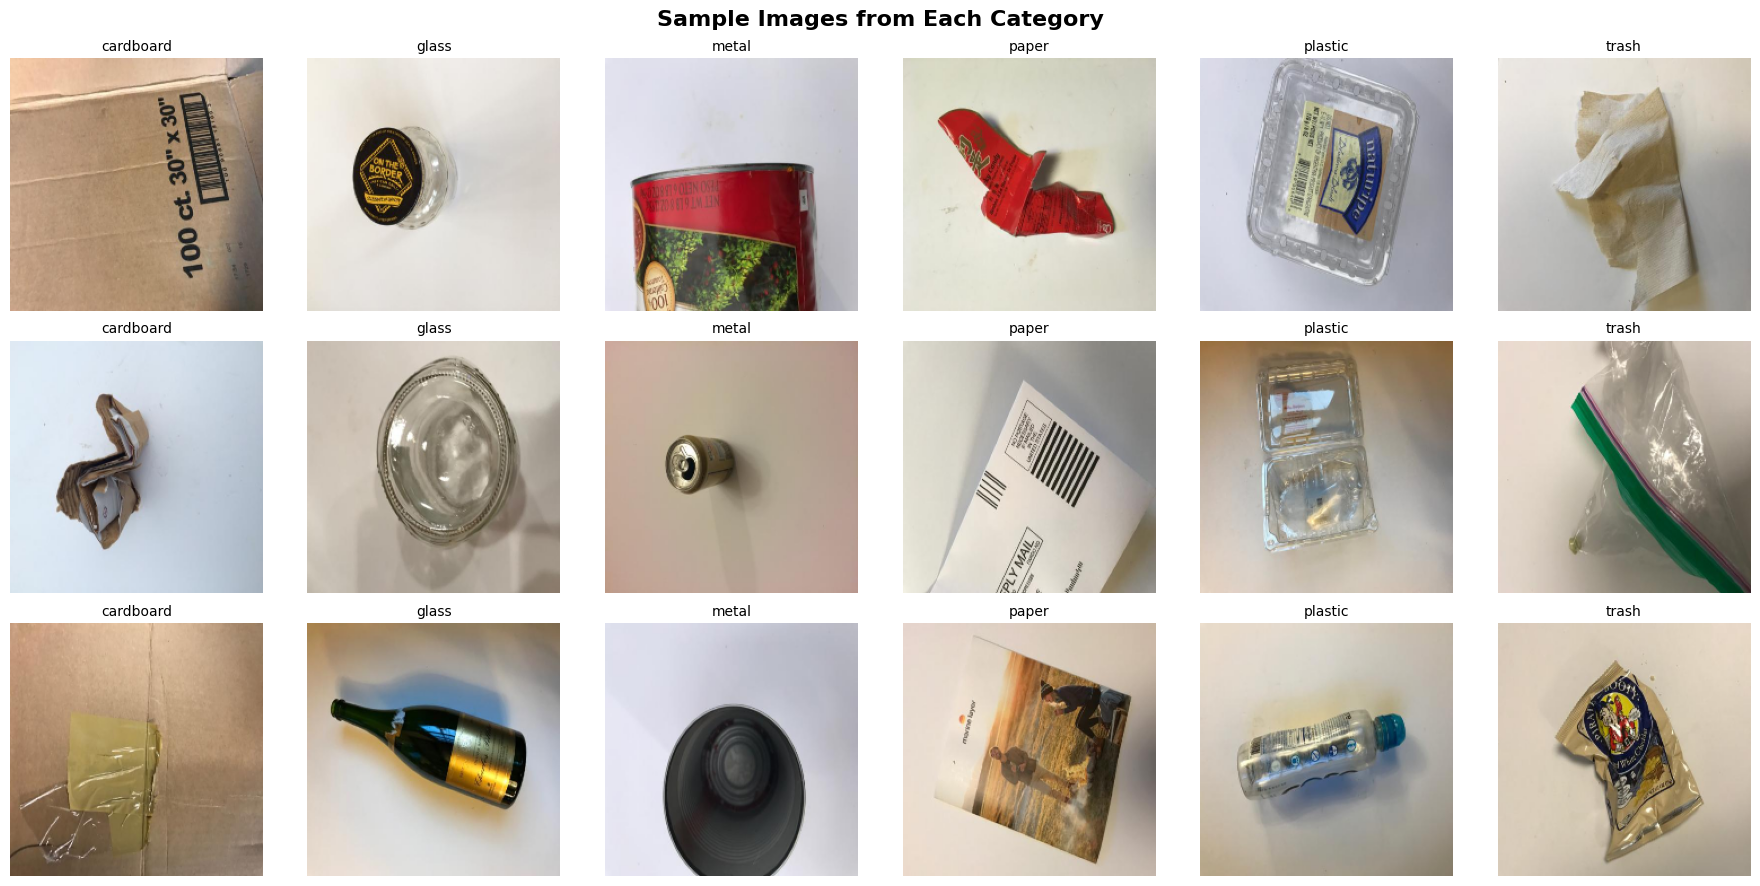

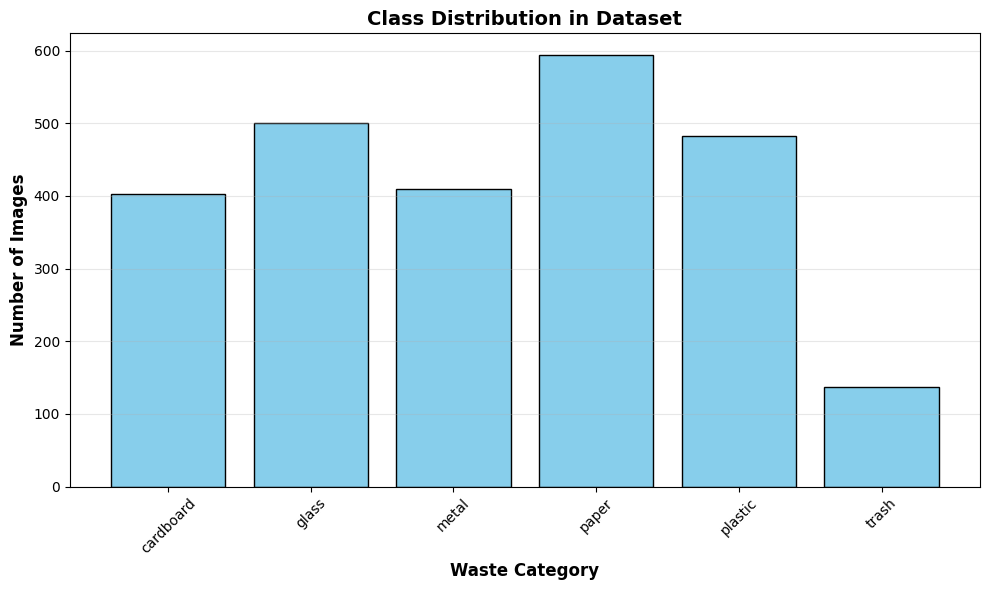

In [ ]:
# ============================================================================
# SECTION 4: DATA VISUALIZATION
# ============================================================================

print("\n" + "=" * 70)
print("VISUALIZING SAMPLE IMAGES")
print("=" * 70)

# Visualize sample images
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
fig.suptitle('Sample Images from Each Category', fontsize=16, fontweight='bold')

for idx, category in enumerate(CATEGORIES):
    # Get 3 random images from each category
    category_indices = np.where(labels == idx)[0]
    sample_indices = np.random.choice(category_indices, 3, replace=False)

    for i, img_idx in enumerate(sample_indices):
        axes[i, idx].imshow(images[img_idx].astype(np.uint8))
        axes[i, idx].set_title(category, fontsize=10)
        axes[i, idx].axis('off')

plt.tight_layout()
plt.show()

# Class distribution plot
plt.figure(figsize=(10, 6))
plt.bar(CATEGORIES, counts, color='skyblue', edgecolor='black')
plt.xlabel('Waste Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SECTION 5: DATA PREPROCESSING & SPLITTING
# ============================================================================

print("\n" + "=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

# Normalize images (0-1 range)
images = images / 255.0
print("✓ Images normalized to [0, 1]")

# Split dataset: 70% train, 20% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.222, random_state=42, stratify=y_temp  # 0.222 * 0.9 ≈ 0.2
)

print(f"\n✓ Data split completed:")
print(f"  Training set:   {len(X_train)} images ({len(X_train)/len(images)*100:.1f}%)")
print(f"  Validation set: {len(X_val)} images ({len(X_val)/len(images)*100:.1f}%)")
print(f"  Test set:       {len(X_test)} images ({len(X_test)/len(images)*100:.1f}%)")

# Convert labels to one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat = keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"\n✓ Labels converted to one-hot encoding")
print(f"  Training labels shape: {y_train_cat.shape}")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

print("\n✓ Data augmentation configured:")
print("  - Rotation: ±20°")
print("  - Width/Height shift: 20%")
print("  - Horizontal flip: Yes")
print("  - Zoom: 20%")



DATA PREPROCESSING
✓ Images normalized to [0, 1]

✓ Data split completed:
  Training set:   1769 images (70.0%)
  Validation set: 505 images (20.0%)
  Test set:       253 images (10.0%)

✓ Labels converted to one-hot encoding
  Training labels shape: (1769, 6)

✓ Data augmentation configured:
  - Rotation: ±20°
  - Width/Height shift: 20%
  - Horizontal flip: Yes
  - Zoom: 20%


In [ ]:
# ============================================================================
# SECTION 6: MODEL ARCHITECTURE
# ============================================================================

print("\n" + "=" * 70)
print("BUILDING CNN MODEL")
print("=" * 70)

def create_cnn_model(input_shape=(224, 224, 3), num_classes=6):
    """Create CNN model as per document specifications"""
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Conv Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def create_transfer_learning_model(base_model_name='MobileNetV2', num_classes=6):
    """Create Transfer Learning model"""
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False,
                                 input_shape=(224, 224, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False,
                             input_shape=(224, 224, 3))

    # Freeze base model layers
    base_model.trainable = False

    # Add custom top layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Choose model type
MODEL_TYPE = 'Transfer'  # Options: 'CNN' or 'Transfer'

if MODEL_TYPE == 'CNN':
    model = create_cnn_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
    print("\n✓ Custom CNN model created")
else:
    model = create_transfer_learning_model(base_model_name='MobileNetV2', num_classes=NUM_CLASSES)
    print("\n✓ Transfer Learning model created (MobileNetV2)")

# Model summary
model.summary()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled:")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Loss: Categorical Crossentropy")
print("  - Metrics: Accuracy")


BUILDING CNN MODEL
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✓ Transfer Learning model created (MobileNetV2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 361,606 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


✓ Model compiled:
  - Optimizer: Adam (lr=0.001)
  - Loss: Categorical Crossentropy
  - Metrics: Accuracy


In [ ]:
# ============================================================================
# SECTION 7: MODEL TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("TRAINING MODEL")
print("=" * 70)

# Callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

# Training parameters
EPOCHS = 30

print(f"\nTraining configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Steps per epoch: {len(X_train) // BATCH_SIZE}")
print(f"\nStarting training...\n")

# Train model
history = model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")


TRAINING MODEL

Training configuration:
  Epochs: 30
  Batch size: 32
  Steps per epoch: 55

Starting training...

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6409 - loss: 0.9637
Epoch 1: val_accuracy improved from -inf to 0.74653, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6411 - loss: 0.9631 - val_accuracy: 0.7465 - val_loss: 0.6656 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6978 - loss: 0.7713
Epoch 2: val_accuracy improved from 0.74653 to 0.75446, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6979 - loss: 0.7714 - val_accuracy: 0.7545 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7249 - loss: 0.7707
Epoch 3: val_accuracy improved from 0.75446 to 0.76832, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7248 - loss: 0.7707 - val_accuracy: 0.7683 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7486 - loss: 0.6778
Epoch 4: val_accuracy improved from 0.76832 to 0.79802, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7486 - loss: 0.6777 - val_accuracy: 0.7980 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7505 - loss: 0.6810
Epoch 5: val_accuracy did not improve from 0.79802
56/56 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7506 - loss: 0.6805 - val_accuracy: 0.7782 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7567 - loss: 0.6360
Epoch 6: val_accuracy did not improve from 0.79802
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7571 - loss: 0.6354 - val_accuracy: 0.7861 - val_loss: 0.5262 - learning_rate: 0.0010
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7970 - loss: 0.5743
Epoch 7: val_accuracy did not improve from 0.79802
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7969 - loss: 0.5744 - val_accuracy: 0.7941 - val_loss: 0.5044 - learning_rate: 0.0010
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 

56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8053 - loss: 0.5402 - val_accuracy: 0.8079 - val_loss: 0.4994 - learning_rate: 0.0010
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8210 - loss: 0.4784
Epoch 9: val_accuracy did not improve from 0.80792
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8208 - loss: 0.4789 - val_accuracy: 0.8079 - val_loss: 0.5132 - learning_rate: 0.0010
Epoch 10/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8096 - loss: 0.5300
Epoch 10: val_accuracy did not improve from 0.80792
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8097 - loss: 0.5295 - val_accuracy: 0.7980 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 11/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8384 - loss: 0.4432
Epoch 11: val_accuracy improved from 0.80792 to 0.83168, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8383 - loss: 0.4436 - val_accuracy: 0.8317 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 12/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8289 - loss: 0.4187
Epoch 12: val_accuracy did not improve from 0.83168
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8291 - loss: 0.4188 - val_accuracy: 0.8257 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 13/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8415 - loss: 0.4359
Epoch 13: val_accuracy did not improve from 0.83168
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8414 - loss: 0.4362 - val_accuracy: 0.8198 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 14/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8360 - loss: 0.4421
Epoch 14: val_accuracy did not improve from 0.83168
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8362 - loss: 0.4417 - val_accuracy: 0.8277 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 15/30
56/56 ━━━━━━━━━━━━━━

56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8660 - loss: 0.3732 - val_accuracy: 0.8376 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 18/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8725 - loss: 0.3693
Epoch 18: val_accuracy did not improve from 0.83762
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8725 - loss: 0.3692 - val_accuracy: 0.8297 - val_loss: 0.4484 - learning_rate: 0.0010
Epoch 19/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8660 - loss: 0.3515
Epoch 19: val_accuracy did not improve from 0.83762
56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8660 - loss: 0.3518 - val_accuracy: 0.8277 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 20/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8713 - loss: 0.3472
Epoch 20: val_accuracy did not improve from 0.83762
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8712 - loss: 0.3477 - val_accuracy: 0.8376 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 21/30
56/56 ━━━━━━━━━━━━━━

56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8681 - loss: 0.3693 - val_accuracy: 0.8475 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 25/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8787 - loss: 0.3230
Epoch 25: val_accuracy did not improve from 0.84752
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8787 - loss: 0.3232 - val_accuracy: 0.8416 - val_loss: 0.4358 - learning_rate: 0.0010
Epoch 26/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8974 - loss: 0.3046
Epoch 26: val_accuracy improved from 0.84752 to 0.86337, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8973 - loss: 0.3046 - val_accuracy: 0.8634 - val_loss: 0.4323 - learning_rate: 0.0010
Epoch 27/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8943 - loss: 0.2817
Epoch 27: val_accuracy did not improve from 0.86337
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8944 - loss: 0.2816 - val_accuracy: 0.8455 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 28/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9147 - loss: 0.2520
Epoch 28: val_accuracy did not improve from 0.86337
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9144 - loss: 0.2528 - val_accuracy: 0.8337 - val_loss: 0.4893 - learning_rate: 0.0010
Epoch 29/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9104 - loss: 0.2580
Epoch 29: val_accuracy did not improve from 0.86337
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9101 - loss: 0.2586 - val_accuracy: 0.8436 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 30/30
56/56 ━━━━━━━━━━━━━━


VISUALIZING TRAINING RESULTS


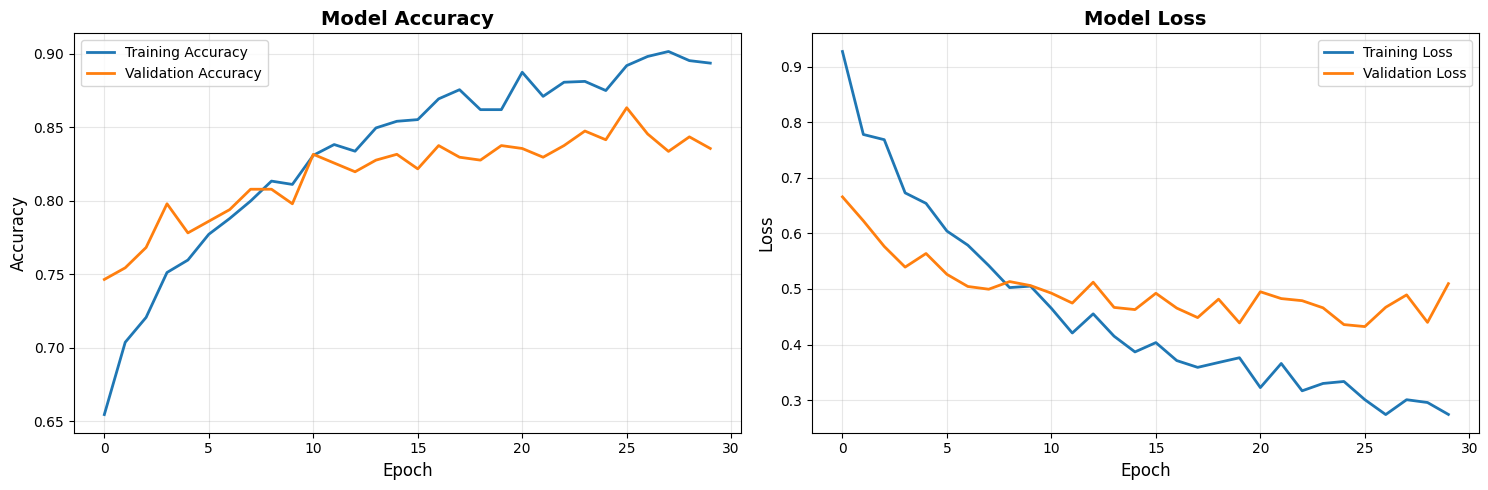

In [ ]:
# ============================================================================
# SECTION 8: TRAINING VISUALIZATION
# ============================================================================

print("\n" + "=" * 70)
print("VISUALIZING TRAINING RESULTS")
print("=" * 70)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SECTION 9: MODEL EVALUATION
# ============================================================================

print("\n" + "=" * 70)
print("MODEL EVALUATION ON TEST SET")
print("=" * 70)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\n📊 Test Results:")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_test, y_pred_classes, target_names=CATEGORIES))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "=" * 70)
print("PER-CLASS ACCURACY")
print("=" * 70)
for idx, category in enumerate(CATEGORIES):
    class_accuracy = cm[idx, idx] / cm[idx].sum() * 100
    print(f"  {category:10s}: {class_accuracy:6.2f}%")


SAMPLE PREDICTIONS


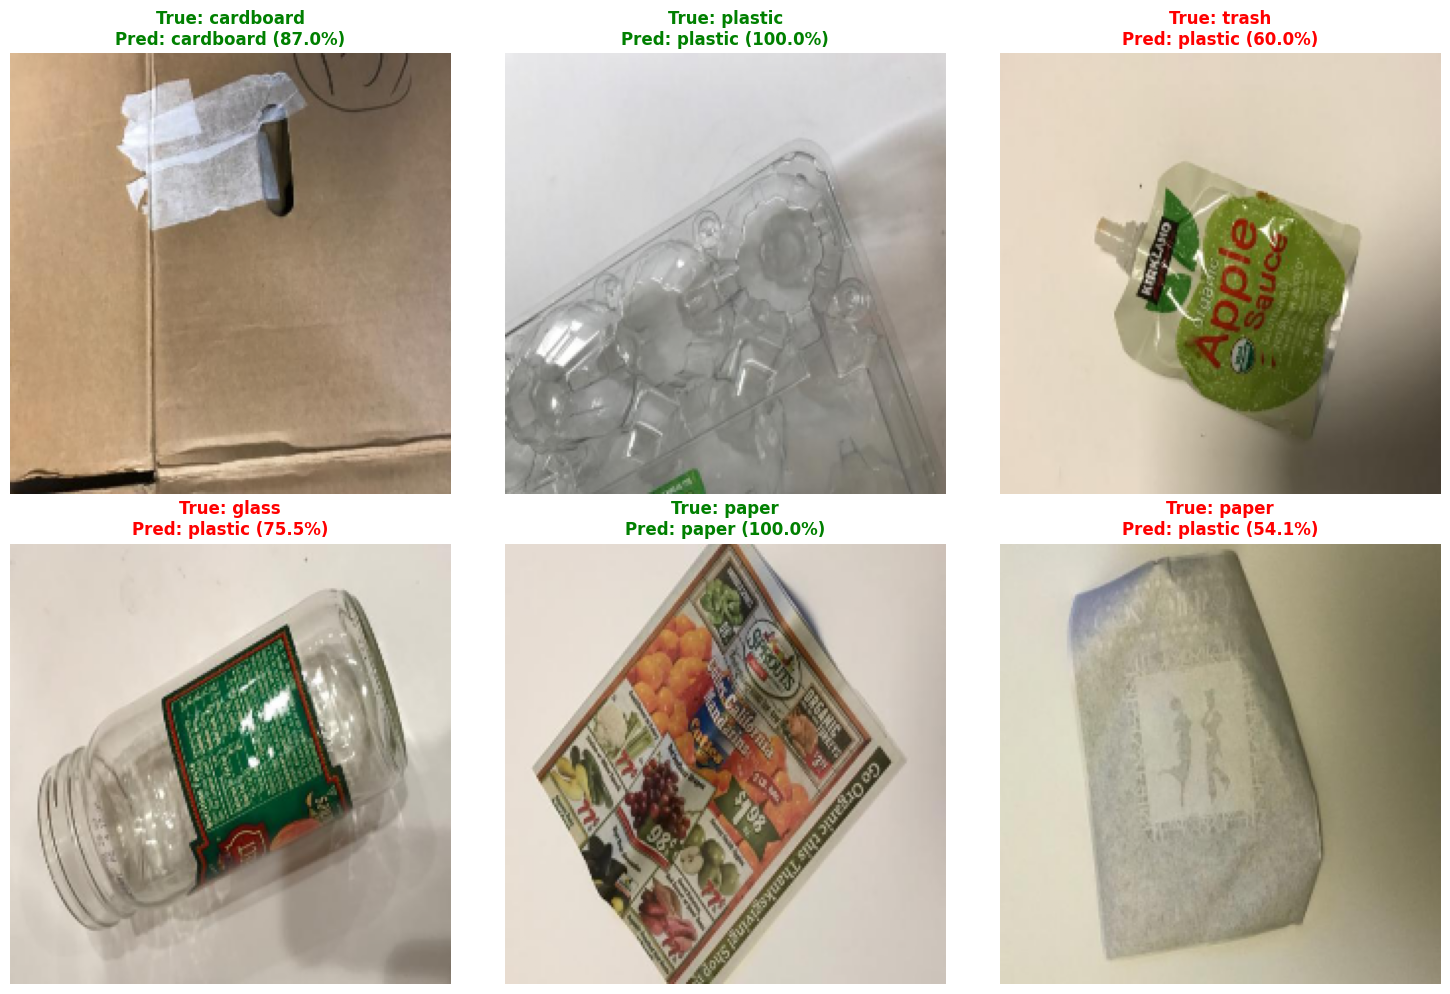

In [ ]:
# ============================================================================
# SECTION 10: PREDICTION DEMONSTRATION
# ============================================================================

print("\n" + "=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

# Select random test samples
num_samples = 6
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    true_label = CATEGORIES[y_test[idx]]
    pred_label = CATEGORIES[y_pred_classes[idx]]
    confidence = y_pred[idx][y_pred_classes[idx]] * 100

    axes[i].imshow(img)
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SECTION 11: SAVE MODEL
# ============================================================================

print("\n" + "=" * 70)
print("SAVING MODEL")
print("=" * 70)

# Save model
model.save('waste_detection_model.h5')
print("✓ Model saved as 'waste_detection_model.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✓ Model architecture saved as 'model_architecture.json'")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("✓ Training history saved as 'training_history.csv'")

# Save metadata
metadata = {
    'categories': CATEGORIES,
    'num_classes': NUM_CLASSES,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'model_type': MODEL_TYPE
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("✓ Metadata saved as 'model_metadata.json'")

print("\n✅ All files saved successfully!")
print("\n" + "=" * 70)
print("TRAINING & EVALUATION COMPLETE!")
print("=" * 70)
print(f"\n🎯 Final Test Accuracy: {test_accuracy*100:.2f}%")
print("\nTo download files from Colab:")
print("  1. Click folder icon on left sidebar")
print("  2. Right-click on files and select 'Download'")
print("\n📁 Files created:")
print("  - best_model.h5")
print("  - waste_detection_model.h5")
print("  - model_architecture.json")
print("  - training_history.csv")
print("  - model_metadata.json")